In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

# Specify the path to your dataset
fpath = "/content/drive/My Drive/archive/train"
dataset_path = fpath

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

# Create a list of target_names based on the directory names
target_names = class_folders
print("Target Names:", target_names)


Number of classes: 2
Target Names: ['nike', 'adidas']


In [ ]:
img_size = 224
batch_size =64
fpath = "/content/drive/My Drive/archive/train"
ffpath="/content/drive/My Drive/archive/test"
fffpath="/content/drive/My Drive/archive/validation"


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'fpath' is the path to your dataset and 'batch_size' is defined

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    fpath,
    target_size=(224, 224),
    subset="training",
    class_mode='categorical',
    batch_size=batch_size
)

valid_gen = datagen.flow_from_directory(
    fffpath,
    target_size=(224, 224),
    batch_size=(batch_size),
    subset='training',
    class_mode='categorical'
)

# For test data
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    ffpath,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback

history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
2/8 [======>.......................] - ETA: 3s - loss: 1.0489 - accuracy: 0.5263  

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 1.1258 - accuracy: 0.4783
Epoch 1: val_accuracy improved from -inf to 0.49091, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 27s 2s/step - loss: 1.1258 - accuracy: 0.4783 - val_loss: 0.7431 - val_accuracy: 0.4909
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 1.4537 - accuracy: 0.4674
Epoch 2: val_accuracy improved from 0.49091 to 0.50909, saving model to best_model.h5
8/8 [==============================] - 10s 1s/step - loss: 1.4537 - accuracy: 0.4674 - val_loss: 2.5516 - val_accuracy: 0.5091
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.5065
Epoch 3: val_accuracy did not improve from 0.50909
8/8 [==============================] - 10s 1s/step - loss: 1.0732 - accuracy: 0.5065 - val_loss: 1.0620 - val_accuracy: 0.4909
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.5152
Epoch 4: val_accuracy did not improve from 0.50909
8/8 [==============================] - 10s 1s/step - loss: 1.0536 - accuracy: 0.5152 - val_loss: 0.9699 - val_accuracy: 0.4909
Epoch 5/100
8/8 [========

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 611ms/step - loss: 0.6893 - accuracy: 0.6333
Train Loss:  0.6908228397369385
Train Accuracy:  0.5586956739425659
--------------------
Validation Loss:  0.692883312702179
Validation Accuracy:  0.4909090995788574
--------------------
Test Loss:  0.689257800579071
Test Accuracy:  0.6333333253860474


In [ ]:
model = load_model('best_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-31-c704b8641e8f>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0]


In [ ]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[16 14]
 [ 8 22]]
              precision    recall  f1-score   support

        nike       0.67      0.53      0.59        30
      adidas       0.61      0.73      0.67        30

    accuracy                           0.63        60
   macro avg       0.64      0.63      0.63        60
weighted avg       0.64      0.63      0.63        60



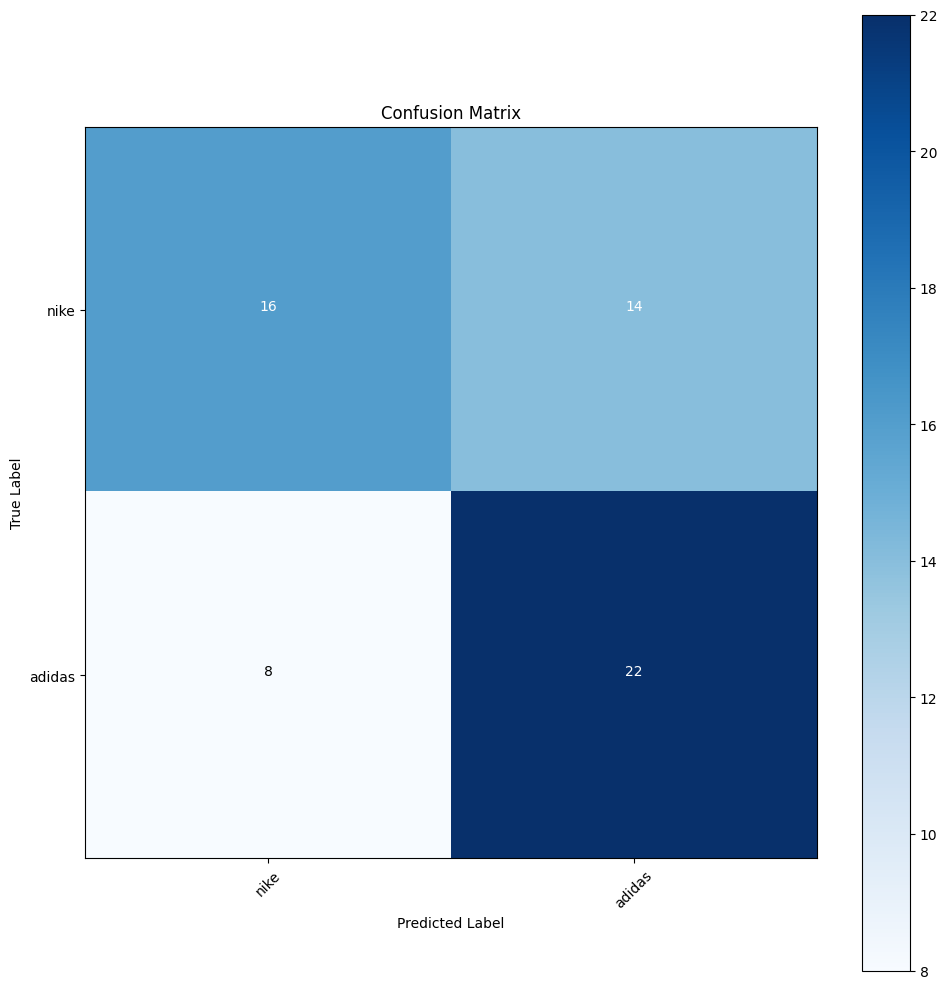

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
4/8 [==============>...............] - ETA: 3s - loss: 0.8615 - accuracy: 0.5039

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.5696
Epoch 1: val_accuracy improved from -inf to 0.49091, saving model to best_model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 17s 2s/step - loss: 0.8026 - accuracy: 0.5696 - val_loss: 1.6890 - val_accuracy: 0.4909
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.5957
Epoch 2: val_accuracy improved from 0.49091 to 0.50909, saving model to best_model_resnet.h5
8/8 [==============================] - 11s 1s/step - loss: 0.7549 - accuracy: 0.5957 - val_loss: 0.9241 - val_accuracy: 0.5091
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6935
Epoch 3: val_accuracy did not improve from 0.50909
8/8 [==============================] - 9s 1s/step - loss: 0.6461 - accuracy: 0.6935 - val_loss: 1.3931 - val_accuracy: 0.5091
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6587
Epoch 4: val_accuracy did not improve from 0.50909
8/8 [==============================] - 10s 1s/step - loss: 0.6402 - accuracy: 0.6587 - val_loss: 1.2007 - val_accuracy: 0.4909
Epoch 5/100
8/8 [==

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 620ms/step - loss: 0.5732 - accuracy: 0.6667
Train Loss:  0.3553749620914459
Train Accuracy:  0.843478262424469
--------------------
Validation Loss:  0.5392179489135742
Validation Accuracy:  0.7272727489471436
--------------------
Test Loss:  0.5731932520866394
Test Accuracy:  0.6666666865348816


In [ ]:
model = load_model('best_model_resnet.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-36-edc74298ee48>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1
 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1]


Confusion Matrix, Without Normalization
[[20 10]
 [10 20]]
              precision    recall  f1-score   support

        nike       0.67      0.67      0.67        30
      adidas       0.67      0.67      0.67        30

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60



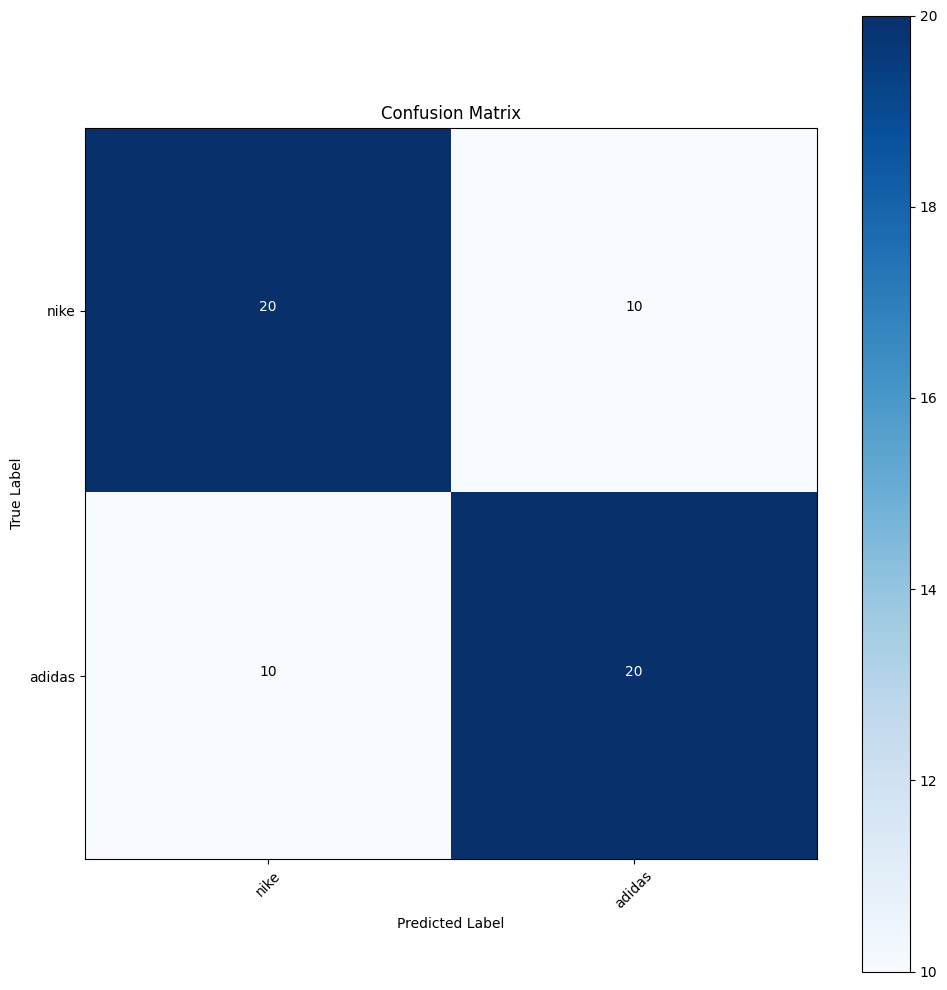

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 0.9304 - accuracy: 0.5707

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.5935
Epoch 1: val_accuracy improved from -inf to 0.50909, saving model to best_model_vgg.h5
8/8 [==============================] - 14s 2s/step - loss: 0.8778 - accuracy: 0.5935 - val_loss: 0.9313 - val_accuracy: 0.5091
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7370
Epoch 2: val_accuracy improved from 0.50909 to 0.54545, saving model to best_model_vgg.h5
8/8 [==============================] - 10s 1s/step - loss: 0.5804 - accuracy: 0.7370 - val_loss: 0.7765 - val_accuracy: 0.5455
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7630
Epoch 3: val_accuracy improved from 0.54545 to 0.58182, saving model to best_model_vgg.h5
8/8 [==============================] - 11s 1s/step - loss: 0.5346 - accuracy: 0.7630 - val_loss: 0.6477 - val_accuracy: 0.5818
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8109
Epoch 4: val_accuracy improved from 0.58182 to 0.65455, saving model to best_model_vgg.h5
8/8 [==============================] - 11s 1s/step - loss: 0.4318 - accuracy: 0.8109 - val_loss: 0.5621 - val_accuracy: 0.6545
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0.4033 - accura

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_vgg.h5')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 1s 602ms/step - loss: 0.8665 - accuracy: 0.7167
Train Loss:  0.020303605124354362
Train Accuracy:  0.9934782385826111
--------------------
Validation Loss:  0.8784945607185364
Validation Accuracy:  0.7454545497894287
--------------------
Test Loss:  0.8664858341217041
Test Accuracy:  0.7166666388511658


In [ ]:
model = load_model('best_model_vgg.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-40-192cfa0cd1d9>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1
 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


Confusion Matrix, Without Normalization
[[18 12]
 [ 5 25]]
              precision    recall  f1-score   support

        nike       0.78      0.60      0.68        30
      adidas       0.68      0.83      0.75        30

    accuracy                           0.72        60
   macro avg       0.73      0.72      0.71        60
weighted avg       0.73      0.72      0.71        60



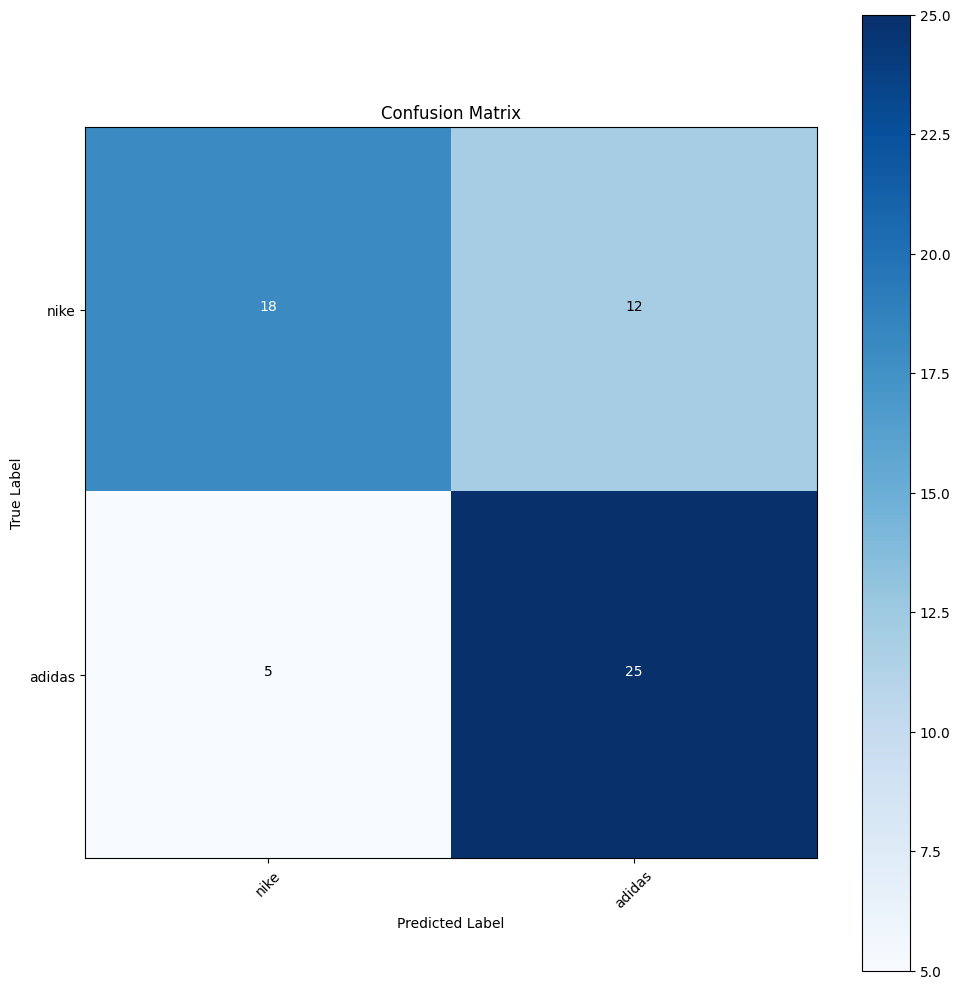

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))